<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/Data_saveTheBest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Create and inspect the data

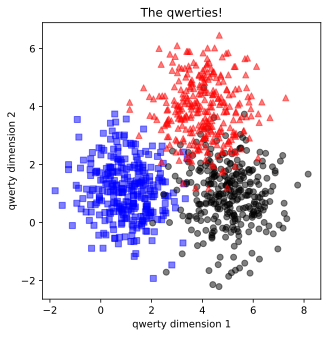

In [61]:
#create data
nPerClust=300
blur=1

A=[1,1]
B=[5,1]
C=[4,4]
#generate data
a=[A[0]+np.random.randn(nPerClust)*blur,A[1]+np.random.randn(nPerClust)*blur]
b=[B[0]+np.random.randn(nPerClust)*blur,B[1]+np.random.randn(nPerClust)*blur]
c=[C[0]+np.random.randn(nPerClust)*blur,C[1]+np.random.randn(nPerClust)*blur]
#true labels
labels_np=np.hstack((np.zeros((nPerClust)),np.ones((nPerClust)),2*np.ones((nPerClust))))
#concatanate into a matrix
data_np=np.hstack((a,b,c)).T
#convert to a pytorch tensor
data=torch.tensor(data_np).float()
labels=torch.tensor(labels_np).long() #note:'long' format for CCE
#show the data
fig=plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [62]:
#specify sizes of the partitions
#order is train,devset,test
partitions=[3*nPerClust-400,200,200]
#split the data
train_data,devset_data,train_labels,devset_labels=train_test_split(data,labels,train_size=partitions[0])
#use scikitlearn to split the data
dev_data,test_data,dev_labels,test_labels=train_test_split(devset_data,devset_labels,train_size=partitions[1])
#print out the sizes
print('Total data size:'+str(data.shape)+'\n')
print('Training data size:'+str(train_data.shape))
print('Devset data size:'+str(dev_data.shape))
print('Test data size:'+str(test_data.shape))

Total data size:torch.Size([900, 2])

Training data size:torch.Size([500, 2])
Devset data size:torch.Size([200, 2])
Test data size:torch.Size([200, 2])


In [63]:

#then convert them into pytorch datasets(note:already converted to tensors)
train_data=TensorDataset(train_data,train_labels)
dev_data=TensorDataset(dev_data,dev_labels)
test_data=TensorDataset(test_data,test_labels)
#FINALLY, translate into dataloader objects
batchsize=30
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader=DataLoader(dev_data,batch_size=dev_data.tensors[0].shape[0])
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

Create and Validate the model

In [64]:
#create a class for the model
def createTheQwertyNet():
  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()
      #input layer
      self.input=nn.Linear(2,8)
      ##hidden layer
      self.fc1=nn.Linear(8,8)
      ##output layer
      self.output=nn.Linear(8,3)
    def forward(self,x):
      x=F.relu(self.input(x))
      x=F.relu(self.fc1(x))
      x=self.output(x)
      return x
   # create the model instance
  net = qwertyNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer




A FUNCTION that trains the model

In [65]:
def function2trainTheModel():
  #New! initialize a dictionary for the best model
  theBestModel={'Accuracy':0,'net':None}
  #number of epochs
  numepochs=100
  #create a new model
  net,lossfun,optimizer=createTheQwertyNet()
  #initialize Losses
  losses=torch.zeros(numepochs)
  trainAcc=[]
  devAcc=[]
  #iterate over epochs
  for epochi in range(numepochs):
    #iterate over training batches
    #switch on training mode
    net.train()
    #loop over training data batches
    batchAcc=[]
    batchLoss=[]
    for X,y in train_loader:
      #forward pass and loss
      yHat=net(X)
      loss=lossfun(yHat,y)
      #backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #loss from this batch
      batchLoss.append(loss.item())
      #compute accuracy over the training batch
      accuracyPct=100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
      batchAcc.append(accuracyPct)
    #now that we have trained through the batches, get their average training accuracy
    trainAcc.append(np.mean(batchAcc))
    #and get average losses across the batches
    losses[epochi]=np.mean(batchLoss)
    #test accuracy
    net.eval()
    X,y=next(iter(dev_loader)) #extract X,y from test dataLoader
    with torch.no_grad(): #deactivates autograd
      yHat=net(X)
    #compute test accuracy
    devAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
    #New! stort this model if it's the best so far
    if devAcc[-1]>=theBestModel['Accuracy']:
      #new best accuracy
      theBestModel['Accuracy']=devAcc[-1].item()
      #model's internal state
      theBestModel['net']=copy.deepcopy(net.state_dict())

    #epochs
  return trainAcc,devAcc,losses,net,theBestModel

plots the result

In [66]:
#RUN the model
trainAcc,devAcc,losses,net,theBestModel=function2trainTheModel()

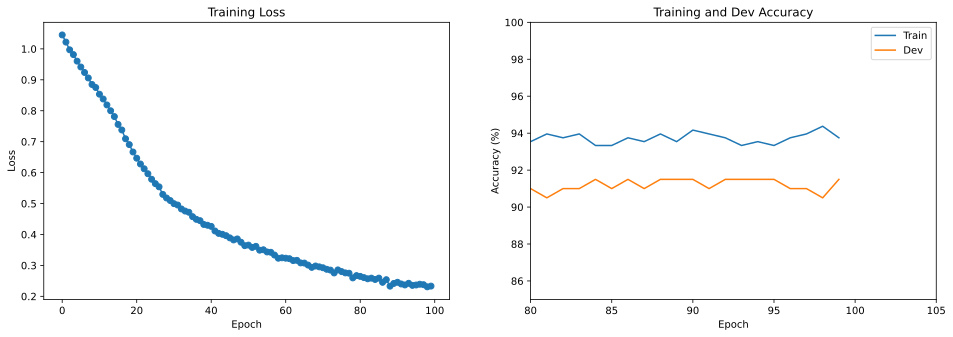

In [67]:
fig,ax=plt.subplots(1,2,figsize=(16,5))
ax[0].plot(losses.detach(),'o-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Training Loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(devAcc,label='Dev')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Training and Dev Accuracy')
ax[1].set_ylim([85,100])
ax[1].set_xlim([80,105])
ax[1].legend()
plt.show()

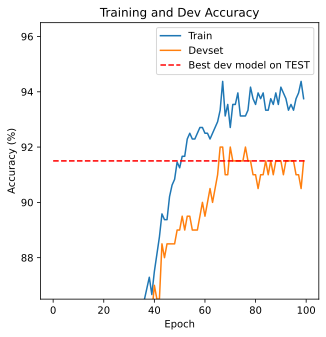

In [69]:
#recreate the best performing model
bestnet=createTheQwertyNet()[0]
bestnet.load_state_dict(theBestModel['net'])
#extract X,y from test dataloader
X,y=next(iter(test_loader))
yHat=bestnet(X)
bestAcc=100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
fig=plt.figure(figsize=(5,5))
plt.plot(trainAcc,label='Train')
plt.plot(devAcc,label='Devset')
plt.plot([0,len(devAcc)],[bestAcc,bestAcc],'r--',label='Best dev model on TEST')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.title('Training and Dev Accuracy')
plt.ylim([bestAcc-5,bestAcc+5])
plt.legend()
